# 02 — Preprocesado y Feature Engineering
**Objetivo:** Limpiar los datos y prepararlos para el modelado, documentando cada decisión tomada y las alternativas descartadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
sns.set_style('whitegrid')
SEED = 42

df = pd.read_csv('src/data_sample/churn.csv')
df = df.drop(columns=['RowNumber','CustomerId','Surname'])
X = df.drop('Exited', axis=1)
y = df['Exited']
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

pd.options.mode.copy_on_write = True

## 1. Train / Test Split

Primero separamos. Todo el preprocesado se aprende en train y se aplica en test.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y)

print(f'Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}')
print(f'Proporción churn train: {y_train.mean()*100:.1f}%')
print(f'Proporción churn test:  {y_test.mean()*100:.1f}%')
print(' Proporciones iguales gracias a stratify ')

Train: 8,000 | Test: 2,000
Proporción churn train: 20.4%
Proporción churn test:  20.3%
 Proporciones iguales gracias a stratify 


## 2. Duplicados

In [4]:
train_full = X_train.copy()
train_full['Exited'] = y_train.values
n_dup = train_full.duplicated().sum()
print(f'Duplicados encontrados: {n_dup}')
if n_dup > 0:
    train_full = train_full.drop_duplicates()
    X_train = train_full.drop('Exited', axis=1)
    y_train = train_full['Exited']
    print(f'Eliminados. Nuevo tamaño: {X_train.shape[0]:,}')
else:
    print('Sin duplicados — no se requiere acción')

Duplicados encontrados: 0
Sin duplicados — no se requiere acción


## 3. Imputación de Nulos

In [5]:
print('Nulos en train antes de imputar:')
print(X_train.isnull().sum()[X_train.isnull().sum()>0]
      if X_train.isnull().sum().sum()>0 else 'Ninguno ')

Nulos en train antes de imputar:
Ninguno 


In [6]:
# PRUEBA DESCARTADA: Imputar con media
# La media se ve distorsionada por outliers extremos
# Ejemplo: si hay edades de 90+, la media sube y el relleno sería irreal

# DECISIÓN FINAL: Mediana para numéricas (robusta a outliers)
cols_nulos_num = [c for c in num_cols if X_train[c].isnull().sum()>0]
cols_nulos_cat = [c for c in cat_cols if X_train[c].isnull().sum()>0]

if cols_nulos_num:
    imputer_num = SimpleImputer(strategy='median')
    X_train[cols_nulos_num] = imputer_num.fit_transform(X_train[cols_nulos_num])
    X_test[cols_nulos_num]  = imputer_num.transform(X_test[cols_nulos_num])
    print(f' Imputadas con mediana: {cols_nulos_num}')
else:
    imputer_num = SimpleImputer(strategy='median')
    imputer_num.fit(X_train[num_cols])
    print(' Imputador ajustado (no había nulos, por si acaso en producción)')

if cols_nulos_cat:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    X_train[cols_nulos_cat] = imputer_cat.fit_transform(X_train[cols_nulos_cat])
    X_test[cols_nulos_cat]  = imputer_cat.transform(X_test[cols_nulos_cat])
    print(f' Imputadas con moda: {cols_nulos_cat}')

 Imputador ajustado (no había nulos, por si acaso en producción)


### ¿Por qué mediana y no media?
```
Ejemplo con Age:
Valores: [25, 30, 35, 40, 92]   ← el 92 es un outlier

Media   = (25+30+35+40+92) / 5 = 44.4  ← distorsionada
Mediana = 35                            ← valor central real
```
La mediana representa mejor al **cliente típico** porque no se ve arrastrada por extremos.

## 4. Outliers — Exploración y Tratamiento

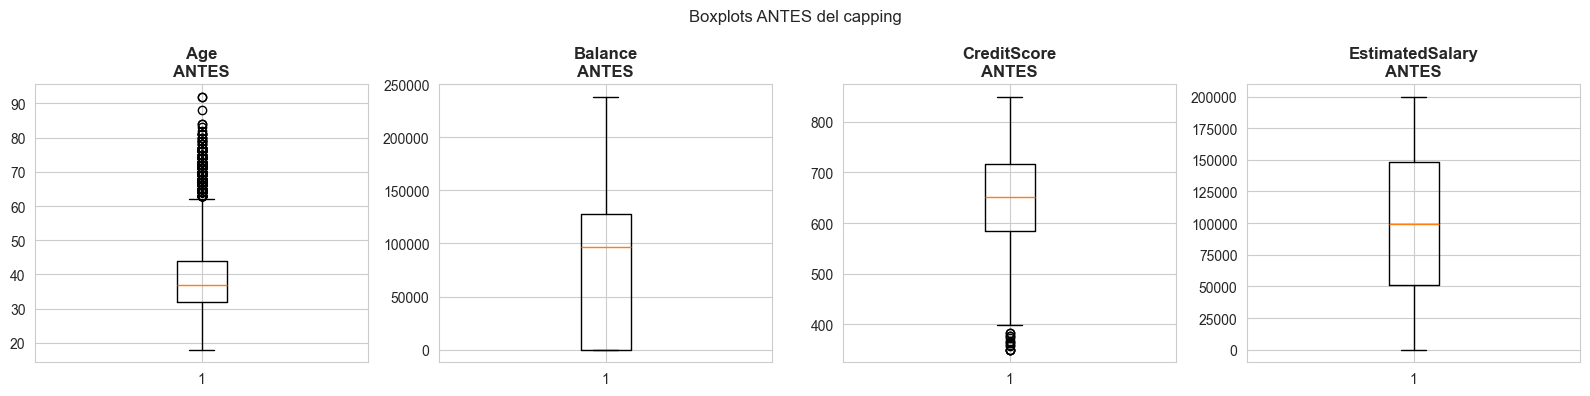

In [8]:
# Visualizamos outliers ANTES del tratamiento
cols_revisar = ['Age','Balance','CreditScore','EstimatedSalary']
fig, axes = plt.subplots(1, len(cols_revisar), figsize=(16,4))
for i, col in enumerate(cols_revisar):
    axes[i].boxplot(X_train[col].dropna())
    axes[i].set_title(f'{col}\nANTES', fontweight='bold')
plt.suptitle('Boxplots ANTES del capping', fontsize=12)
plt.tight_layout()
plt.show()

In [11]:
# PRUEBA DESCARTADA: Eliminar filas con outliers
# → Perdemos datos válidos. En producción no podemos "eliminar" un cliente real.

# DECISIÓN FINAL: Capping P1-P99 (Winsorización)
# Los valores extremos se recortan al límite razonable SIN eliminar registros
capping_bounds = {}
cols_capping = ['Age','Balance','CreditScore','EstimatedSalary']

print(' Aplicando capping P1-P99:')
for col in cols_capping:
    p1  = X_train[col].quantile(0.01)
    p99 = X_train[col].quantile(0.99)
    capping_bounds[col] = (p1, p99)
    X_train[col] = X_train[col].clip(lower=p1, upper=p99)
    X_test[col]  = X_test[col].clip(lower=p1, upper=p99)
    print(f'  {col:20s}: [{p1:.1f}, {p99:.1f}]')

print('\n Límites aprendidos en train y aplicados en test')

 Aplicando capping P1-P99:
  Age                 : [21.0, 72.0]
  Balance             : [0.0, 185932.2]
  CreditScore         : [431.0, 850.0]
  EstimatedSalary     : [2002.5, 198032.9]

 Límites aprendidos en train y aplicados en test


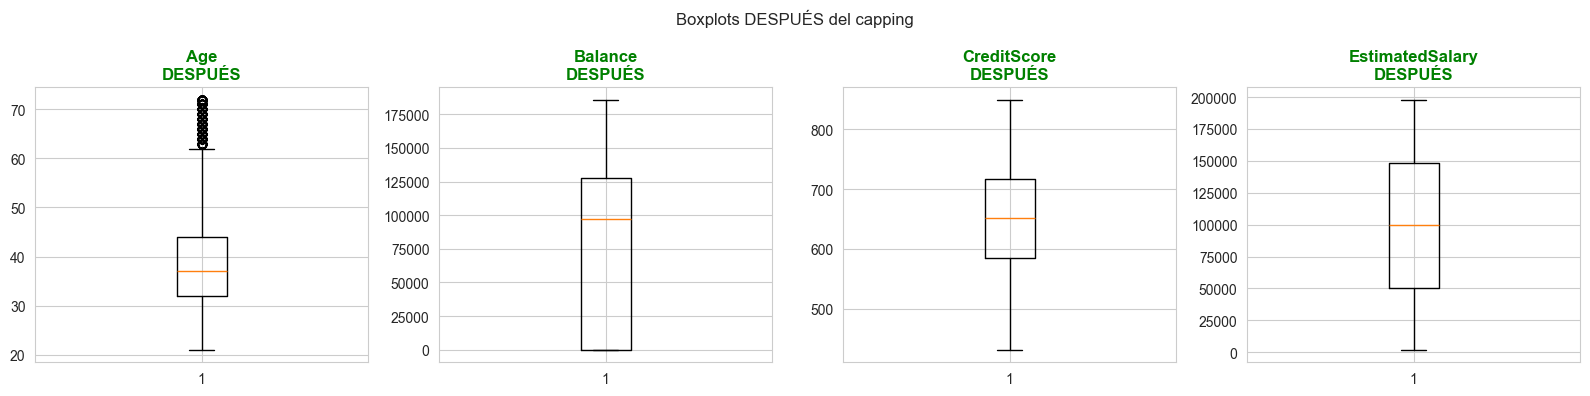

In [12]:
# Visualizamos DESPUÉS del capping
fig, axes = plt.subplots(1, len(cols_capping), figsize=(16,4))
for i, col in enumerate(cols_capping):
    axes[i].boxplot(X_train[col].dropna())
    axes[i].set_title(f'{col}\nDESPUÉS', fontweight='bold', color='green')
plt.suptitle('Boxplots DESPUÉS del capping', fontsize=12)
plt.tight_layout()
plt.show()

### Resultado del tratamiento de outliers
Comparando los boxplots antes y después del capping:
- Las cajas son más compactas y representativas
- Los bigotes llegan hasta valores razonables
- **No hemos eliminado ningún registro** — solo recortado los extremos

Los límites se calculan en train y se aplican igual en test → sin data leakage 

## 5. Feature Engineering

In [13]:
# Nueva feature: balance_per_product
# Idea del EDA: clientes con saldo alto concentrado en pocos productos
# tienen más facilidad para irse a la competencia con una buena oferta

X_train['balance_per_product'] = X_train['Balance'] / (X_train['NumOfProducts'] + 1)
X_test['balance_per_product']  = X_test['Balance']  / (X_test['NumOfProducts'] + 1)

# Verificamos correlación con el target
temp = X_train.copy()
temp['Exited'] = y_train.values
corr_nueva = temp['balance_per_product'].corr(temp['Exited'])
print(f' Nueva feature: balance_per_product')
print(f'   Correlación con target: {corr_nueva:.4f}')
print(f'   {"→ Aporta valor " if abs(corr_nueva)>0.05 else "→ Correlación débil ⚠️"}')

 Nueva feature: balance_per_product
   Correlación con target: 0.1141
   → Aporta valor 


In [14]:
# One-Hot Encoding de variables categóricas
# PRUEBA DESCARTADA: Label Encoding
# → Asignaría orden implícito: France=0, Germany=1, Spain=2
# → Implica que Spain > Germany > France, lo cual es falso

# DECISIÓN FINAL: One-Hot Encoding con drop_first=True
print(f'Categóricas a encodear: {cat_cols}')
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)
print(f'\nFeatures antes:  {X_train.shape[1]}')
print(f'Features después: {X_train_enc.shape[1]}')
print(f'Nuevas columnas: {[c for c in X_train_enc.columns if c not in X_train.columns]}')

Categóricas a encodear: ['Geography', 'Gender']

Features antes:  11
Features después: 12
Nuevas columnas: ['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [16]:
# StandardScaler — estandariza a media=0 y std=1
# Imprescindible para Logistic Regression y KNN
# Los árboles no lo necesitan pero no les perjudica
num_cols_final = X_train_enc.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train_enc.copy()
X_train_scaled[num_cols_final] = scaler.fit_transform(X_train_enc[num_cols_final])
X_test_scaled = X_test_enc.copy()
X_test_scaled[num_cols_final] = scaler.transform(X_test_enc[num_cols_final])

print(f' StandardScaler aplicado')
print(f'   Shape final — Train: {X_train_scaled.shape} | Test: {X_test_scaled.shape}')
print()
print('Features finales:', list(X_train_scaled.columns))

 StandardScaler aplicado
   Shape final — Train: (8000, 12) | Test: (2000, 12)

Features finales: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'balance_per_product', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


### ¿Por qué One-Hot y no Label Encoding?
```
Label Encoding:  France=0, Germany=1, Spain=2
→ Implica Germany > France → orden falso

One-Hot Encoding:
  France   → [1, 0, 0]
  Germany  → [0, 1, 0]
  Spain    → [0, 0, 1]
→ Sin orden, cada país es independiente 
```
`drop_first=True` elimina una columna por variable para evitar **multicolinealidad perfecta**.

## 6. Resumen del Preprocesado

| Paso | Decisión | Justificación |
|---|---|---|
| Eliminar identificadores | RowNumber, CustomerId, Surname | No aportan información predictiva |
| Duplicados | Eliminados en train | Evitan sesgo en el aprendizaje |
| Missings | Mediana (numéricas) / Moda (categóricas) | Robusta a outliers, fit solo en train |
| Outliers | Capping P1-P99 | Conserva todos los registros |
| Nueva feature | `balance_per_product` | Captura concentración de dinero por producto |
| Encoding | One-Hot con drop_first | Sin orden implícito entre categorías |
| Escalado | StandardScaler | Necesario para LR y KNN, fit solo en train 